Імпорти необхідних бібліотек

In [24]:
from utils.spark_utils import create_spark_session
from pyspark.sql.functions import col,count,avg,when, coalesce,round,lit,sum as _sum
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

Завантаження даних, які будуть використовуватися для відповідей на бізнес-запитання

In [5]:
spark = create_spark_session()
flights_df = spark.read.csv("../output/FactFlight.csv", header=True, inferSchema=True)
dim_time = spark.read.csv("../output/Dim_Time.csv", header=True, inferSchema=True)
dim_date = spark.read.csv("../output/Dim_Date.csv", header=True, inferSchema=True)
dim_airport = spark.read.csv("../output/Dim_Airport.csv", header=True, inferSchema=True)
dim_operating_airline = spark.read.csv("../output/Dim_Operating_Airline.csv", header=True, inferSchema=True)

## Filters

### Скільки нічних рейсів (після 22:00) прибули вчасно (status = "on_time")?

In [6]:
night_on_time_cnt = (
    flights_df.alias("f")
    .join(dim_time.alias("t"), col("f.departure_time_id") == col("t.time_id"), "left")
    .filter(col("t.hour") >= 22)                # ніч = після 22:00
    .filter(col("f.status") == "on_time")       # статус з факту
    .count()
)
print("Нічних рейсів, що прибули вчасно:", night_on_time_cnt)

Нічних рейсів, що прибули вчасно: 707218


In [21]:
night_stats_by_hour = (
    flights_df.alias("f")
    .join(dim_time.alias("t"), col("f.departure_time_id") == col("t.time_id"), "left")
    .filter((col("t.hour") >= 21) | (col("t.hour") <= 3))
    .groupBy(col("t.hour"))
    .agg(
        count("*").alias("total_flights"),
        count(when(col("f.status") == "on_time", True)).alias("on_time_flights")
    )
    .withColumn("on_time_ratio", col("on_time_flights") / col("total_flights"))
    .orderBy(col("t.hour"))
)
night_stats_by_hour.show()

+----+-------------+---------------+-------------------+
|hour|total_flights|on_time_flights|      on_time_ratio|
+----+-------------+---------------+-------------------+
|   1|         1228|            724| 0.5895765472312704|
|   2|          374|            159|0.42513368983957217|
|   3|          176|            110|              0.625|
|  21|       919338|         707821| 0.7699246631815502|
|  22|       698327|         535770| 0.7672193685766124|
|  23|       277226|         170379| 0.6145852120652464|
|  24|         2104|           1069| 0.5080798479087453|
+----+-------------+---------------+-------------------+



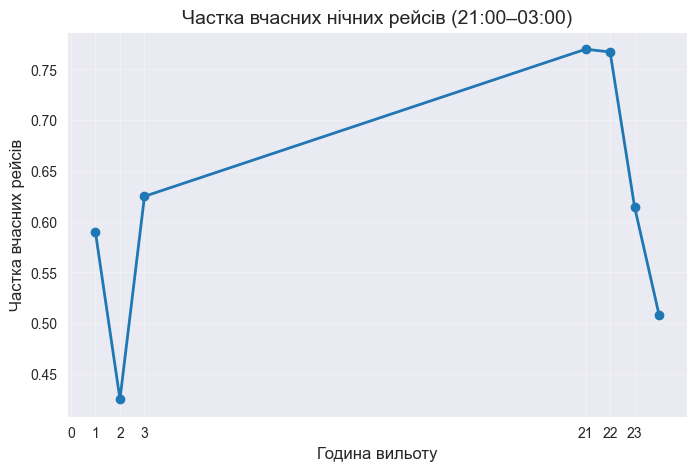

In [22]:
pdf = night_stats_by_hour.toPandas().sort_values("hour")

plt.figure(figsize=(8, 5))
plt.plot(pdf["hour"], pdf["on_time_ratio"], marker="o", linewidth=2)
plt.title("Частка вчасних нічних рейсів (21:00–03:00)", fontsize=14)
plt.xlabel("Година вильоту", fontsize=12)
plt.ylabel("Частка вчасних рейсів", fontsize=12)
plt.grid(True, alpha=0.3)


plt.xticks([21,22, 23, 0, 1, 2, 3])
plt.show()

### Скільки рейсів було скасовано в зимові місяці (грудень, січень, лютий) за всі роки?

In [18]:
winter_cancelled_by_month = (
    flights_df.alias("f")
    .join(dim_date.alias("d"), "date_id", "left")
    .filter(col("d.month").isin(12, 1, 2))
    .filter(col("f.status") == "cancelled")
    .groupBy(col("d.month"))
    .agg(count("*").alias("cancelled_count"))
    .orderBy(col("d.month"))
)
winter_cancelled_by_month.show()

+-----+---------------+
|month|cancelled_count|
+-----+---------------+
|    1|          80518|
|    2|          73243|
|   12|          33023|
+-----+---------------+



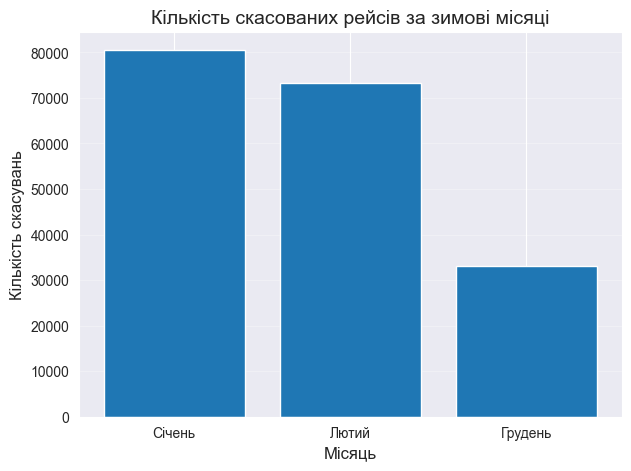

In [19]:
pdf = winter_cancelled_by_month.toPandas().sort_values("month")

month_labels = {12: "Грудень", 1: "Січень", 2: "Лютий"}

plt.figure(figsize=(7, 5))
plt.bar(pdf["month"].map(month_labels), pdf["cancelled_count"])
plt.title("Кількість скасованих рейсів за зимові місяці", fontsize=14)
plt.xlabel("Місяць", fontsize=12)
plt.ylabel("Кількість скасувань", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.show()

## JOIN

### Скільки рейсів виконувала кожна операційна авіакомпанія (Dim_Operating_Airline) у вихідні дні по місяцях?

In [23]:
ops_weekend_pivot = (
    flights_df.alias("f")
    .join(dim_operating_airline.alias("o"), "operating_airline_id", "left")
    .join(dim_date.alias("d"), "date_id", "left")
    .filter(col("d.is_weekend") == True)
    .groupBy(col("o.airline_name"), col("d.year"))
    .pivot("month", list(range(1,13)))       # 1..12
    .agg(count("*"))
    .orderBy(col("d.year"), col("o.airline_name"))
)

ops_weekend_pivot.show(50, truncate=False)

+-----------------------------------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|airline_name                             |year|1    |2    |3    |4    |5    |6    |7    |8    |9    |10   |11   |12   |
+-----------------------------------------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|Air Wisconsin Airlines Corp              |2018|1421 |1694 |2429 |2589 |2194 |2585 |2477 |1996 |2587 |2134 |2383 |2656 |
|Alaska Airlines Inc.                     |2018|3772 |NULL |4409 |6359 |5673 |NULL |6816 |NULL |6769 |5411 |5331 |6503 |
|Allegiant Air                            |2018|1742 |2035 |2706 |2515 |2132 |2907 |3139 |2238 |2027 |2165 |2336 |2762 |
|American Airlines Inc.                   |2018|NULL |NULL |NULL |NULL |NULL |NULL |NULL |19437|23000|19084|19489|23813|
|Cape Air                                 |2018|88   |88   |99   |99   |88   |NULL |NULL |NULL |NULL |NULL |NULL |NULL |
|Capital Cargo International    

In [28]:
ops_weekend_totals = (
    flights_df.alias("f")
    .join(dim_operating_airline.alias("o"), "operating_airline_id", "left")
    .join(dim_date.alias("d"), "date_id", "left")
    .filter(col("d.is_weekend") == True)
    .groupBy(col("o.airline_name"))
    .agg(_sum(lit(1)).alias("total_weekend_flights"))
    .orderBy(col("total_weekend_flights").desc())
)

ops_weekend_totals.show(10, truncate=False)

+----------------------+---------------------+
|airline_name          |total_weekend_flights|
+----------------------+---------------------+
|Southwest Airlines Co.|1478568              |
|Delta Air Lines Inc.  |883051               |
|American Airlines Inc.|864044               |
|SkyWest Airlines Inc. |862765               |
|United Air Lines Inc. |639786               |
|Republic Airlines     |337066               |
|JetBlue Airways       |307851               |
|Envoy Air             |295231               |
|Comair Inc.           |264901               |
|Alaska Airlines Inc.  |252099               |
+----------------------+---------------------+
only showing top 10 rows



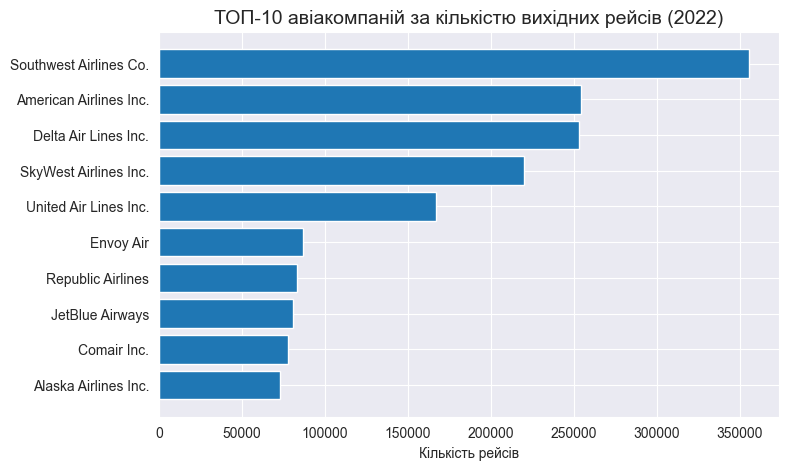

In [30]:
ops_weekend_total = (
    ops_weekend_pivot
    .withColumn("total_weekend_flights", sum([col(str(m)) for m in range(1,13)]))
    .select("airline_name", "year", "total_weekend_flights")
)
pdf = ops_weekend_total.toPandas()
subset = pdf[pdf["year"] == 2019].sort_values("total_weekend_flights", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(subset["airline_name"], subset["total_weekend_flights"])
plt.title("ТОП-10 авіакомпаній за кількістю вихідних рейсів (2022)", fontsize=14)
plt.xlabel("Кількість рейсів")
plt.gca().invert_yaxis()
plt.show()


## Group By

### Яка середня тривалість польоту (air_time) по періодах дня (ранок/день/вечір/ніч)?


In [31]:
avg_airtime_by_period = (
    flights_df.alias("f")
    .join(dim_time.alias("t"), col("f.departure_time_id") == col("t.time_id"), "left")
    .withColumn(
        "period",
        when((col("t.hour") >= 5) & (col("t.hour") < 12), "ранок")
        .when((col("t.hour") >= 12) & (col("t.hour") < 17), "день")
        .when((col("t.hour") >= 17) & (col("t.hour") < 22), "вечір")
        .otherwise("ніч")
    )
    .groupBy("period")
    .agg(avg(coalesce(col("actual_elapsed_time"), col("crs_elapsed_time"))).alias("avg_air_time"))
    .orderBy("period")
)

avg_airtime_by_period.show(truncate=False)

+------+------------------+
|period|avg_air_time      |
+------+------------------+
|вечір |131.11367046155328|
|день  |129.99540133635793|
|ніч   |138.13275989229433|
|ранок |132.07966636707158|
+------+------------------+



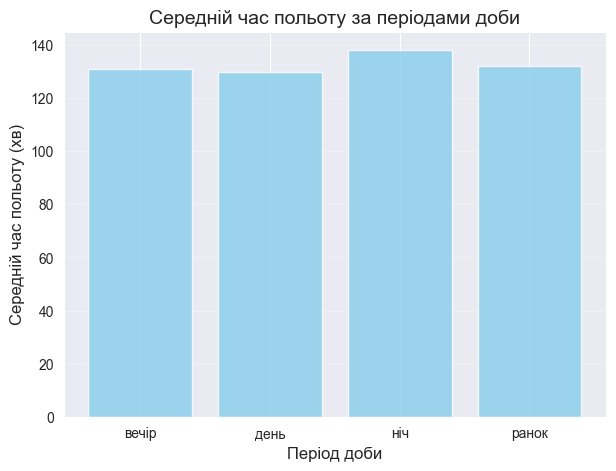

In [32]:
pdf = avg_airtime_by_period.toPandas()

plt.figure(figsize=(7,5))
plt.bar(pdf["period"], pdf["avg_air_time"], color="skyblue", alpha=0.8)
plt.title("Середній час польоту за періодами доби", fontsize=14)
plt.xlabel("Період доби", fontsize=12)
plt.ylabel("Середній час польоту (хв)", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.show()

### Який відсоток скасованих рейсів по штатах відправлення?

In [38]:
cancel_rate_by_state = (
    flights_df.alias("f")
    .join(dim_airport.alias("ao"), col("f.origin_airport_id") == col("ao.airport_id"), "left")
    .groupBy(col("ao.state_name").alias("state"))
    .agg(
        _sum(when(col("f.status") == "cancelled", 1).otherwise(0)).alias("cancelled"),
        count("*").alias("total")
    )
    .withColumn("cancel_rate_pct", round(col("cancelled") / col("total") * 100, 2))
    .orderBy(col("cancel_rate_pct").desc(), col("state"))
)

cancel_rate_by_state.show(truncate=False)

+--------------+---------+-------+---------------+
|state         |cancelled|total  |cancel_rate_pct|
+--------------+---------+-------+---------------+
|Delaware      |7        |165    |4.24           |
|New Jersey    |24825    |601718 |4.13           |
|Maine         |3001     |73609  |4.08           |
|Vermont       |1502     |38431  |3.91           |
|Rhode Island  |2495     |68011  |3.67           |
|New York      |48793    |1340734|3.64           |
|North Dakota  |2851     |80845  |3.53           |
|New Hampshire |1326     |37788  |3.51           |
|Illinois      |60971    |1790511|3.41           |
|South Dakota  |2159     |63481  |3.4            |
|West Virginia |1009     |29712  |3.4            |
|Louisiana     |9992     |303320 |3.29           |
|Maryland      |13275    |406623 |3.26           |
|Virginia      |34279    |1083884|3.16           |
|South Carolina|8482     |269758 |3.14           |
|Kansas        |2019     |65060  |3.1            |
|Connecticut   |3225     |10524

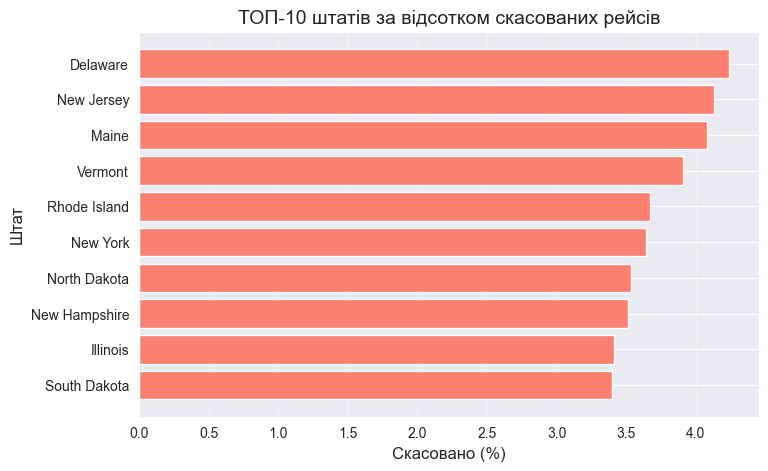

In [42]:
pdf = cancel_rate_by_state.toPandas()
pdf_top = pdf.sort_values("cancel_rate_pct", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(pdf_top["state"], pdf_top["cancel_rate_pct"], color="salmon")
plt.title("ТОП-10 штатів за відсотком скасованих рейсів", fontsize=14)
plt.xlabel("Скасовано (%)", fontsize=12)
plt.ylabel("Штат", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.show()

## Window Functions

### Яка середня затримка вильоту по кожному аеропорту з урахуванням останніх 7 днів?

In [44]:
delay_trend = (
    flights_df.alias("f")
    .join(dim_date.alias("d"), "date_id", "left")
    .join(dim_airport.alias("a"), col("f.origin_airport_id") == col("a.airport_id"), "left")
    .select(
        col("a.airport_code").alias("airport"),
        col("d.flight_date").alias("date"),
        col("f.dep_delay_minutes").alias("dep_delay")
    )
)
window_spec = (
    Window.partitionBy("airport")
          .orderBy("date")
          .rowsBetween(-6, 0)   # 7 днів поточний + 6 попередніх
)
moving_avg_delay = (
    delay_trend
    .withColumn("moving_avg_dep_delay", round(avg(col("dep_delay")).over(window_spec), 2))
    .orderBy("airport", "date")
)

moving_avg_delay.show(20, truncate=False)

+-------+----------+---------+--------------------+
|airport|date      |dep_delay|moving_avg_dep_delay|
+-------+----------+---------+--------------------+
|ABE    |2018-01-01|37.0     |37.0                |
|ABE    |2018-01-01|28.0     |32.5                |
|ABE    |2018-01-01|21.0     |28.67               |
|ABE    |2018-01-01|0.0      |21.5                |
|ABE    |2018-01-01|2.0      |17.6                |
|ABE    |2018-01-01|13.0     |16.83               |
|ABE    |2018-01-02|0.0      |14.43               |
|ABE    |2018-01-02|0.0      |9.14                |
|ABE    |2018-01-02|561.0    |85.29               |
|ABE    |2018-01-02|0.0      |82.29               |
|ABE    |2018-01-02|21.0     |85.29               |
|ABE    |2018-01-02|0.0      |85.0                |
|ABE    |2018-01-02|33.0     |87.86               |
|ABE    |2018-01-02|2.0      |88.14               |
|ABE    |2018-01-03|9.0      |89.43               |
|ABE    |2018-01-03|0.0      |9.29                |
|ABE    |201

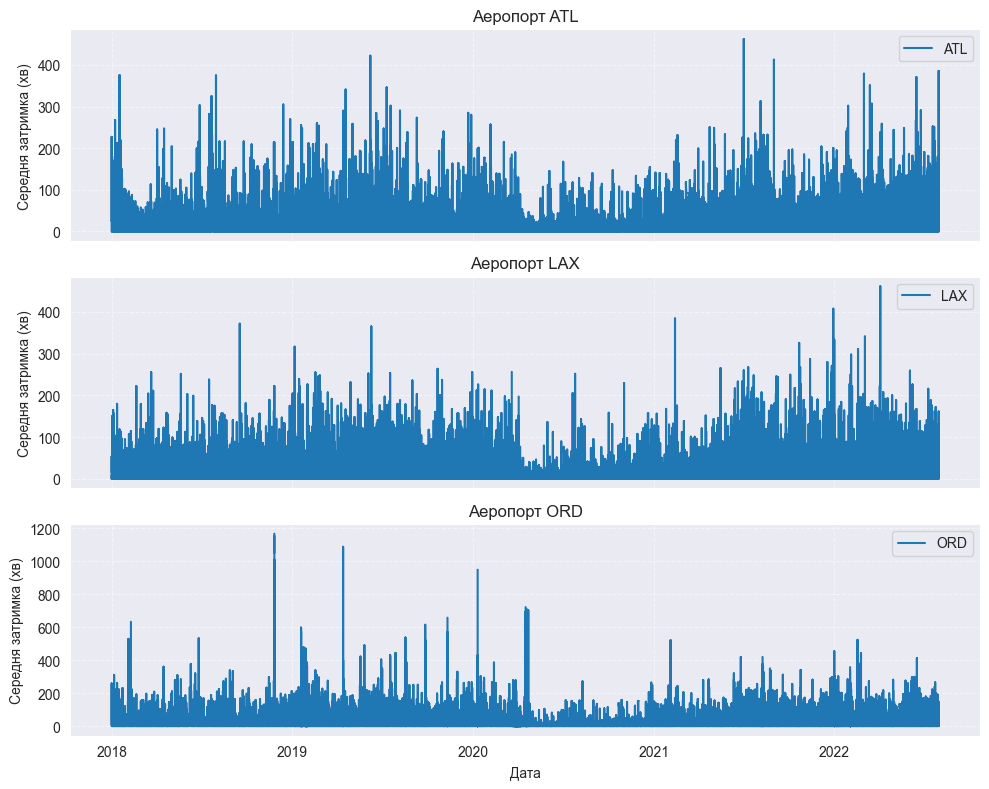

In [45]:
pdf = moving_avg_delay.toPandas()
selected_airports = ["ATL", "LAX", "ORD"]
filtered = pdf[pdf["airport"].isin(selected_airports)]

fig, axes = plt.subplots(len(selected_airports), 1, figsize=(10, 8), sharex=True)

for ax, airport in zip(axes, selected_airports):
    subset = filtered[filtered["airport"] == airport]
    ax.plot(subset["date"], subset["moving_avg_dep_delay"], label=airport, color="tab:blue")
    ax.set_title(f"Аеропорт {airport}")
    ax.set_ylabel("Середня затримка (хв)")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.xlabel("Дата")
plt.tight_layout()
plt.show()

**Висновки:**

- Було проаналізовано нічні рейси з використанням filters для відбору вильотів у проміжку 21:00–03:00 зі статусом "on_time".
З графіка видно, що найвища частка вчасних прибуттів у рейсів, що вилітають о 21–22 год (понад 75%).
Після 23:00 частка падає до ~60%, далі мінімум спостерігається о 1–2 год (близько 40–45%), а о 3-й годині показник відновлюється до ~63%. Загалом за цими умовами відбору вчасно прибули 707 218 нічних рейсів. Практично це означає, що найстабільніше вікно для пунктуальних нічних вильотів - 21–22 год, тоді як спад о 1–2 год може відображати нічні операційні обмеження й стикування; після 03:00 пунктуальність поступово поліпшується.

- Далі було проаналізовано зимові місяці за допомогою filters для виявлення скасованих рейсів.
До вибірки потрапили лише дати з грудня по лютий, де у факт таблиці статус рейсу дорівнював "cancelled". Результати показали, що найбільше скасувань відбулося у січні (80 518 рейсів), трохи менше - у лютому (73 243), тоді як грудень (33 023) мав найнижчий показник. Отримана тенденція свідчить про вплив зимових погодних умов, які особливо у січні та лютому спричиняють підвищену кількість відмін авіарейсів.

- Також проведено аналіз вихідних рейсів із використанням JOIN для поєднання факт таблиці з вимірами operating_airline та date.
Об’єднання дозволило пов’язати інформацію про рейси з назвами авіакомпаній і календарними даними, зокрема визначити, чи відбувався виліт у вихідний день (is_weekend = True). Отримані результати показали, що найбільше вихідних рейсів виконала Southwest Airlines Co. - понад 1,47 млн, далі Delta Air Lines Inc. (883 тис.) та American Airlines Inc. (864 тис.). Таким чином, за результатами з’єднання видно, що саме великі національні перевізники забезпечують основну частку авіаперевезень у вихідні дні, тоді як регіональні авіалінії мають значно менший трафік.

- Було проведено аналіз середнього часу польоту з використанням GROUP BY для агрегування даних за періодами доби.
Після приєднання виміру time та класифікації годин на категорії ранок, день, вечір, ніч, обчислено середній показник тривалості польоту для кожної групи. Результати показали, що найдовший середній час польоту спостерігається вночі - близько 138 хвилин, тоді як удень - найкоротший (≈130 хв).

- Щоб оцінити географію відмін, спершу визначено рівень скасувань за штатами (cancelled / total * 100).
Далі поєднано фактичні рейси з виміром airport через origin_airport_id, після чого виконано GROUP BY state та обчислено частку скасованих вильотів. За графіком у топі - Delaware (~4.2%), New Jersey (~4.1%), Maine (~4.0%) та Vermont (~3.9%), тоді як інші штати з першої десятки мають показники близько 3.4–3.8%. Картина узгоджується з впливом погодних факторів і завантаженості вузлових аеропортів у північно-східному регіоні, де скасування трапляються частіше.

- Було проведено аналіз динаміки затримок вильоту з використанням window function для обчислення рухомого середнього за останні 7 днів. За допомогою з’єднання факт таблиці з вимірами date та airport побудовано часовий ряд середніх затримок по основних аеропортах - ATL, LAX та ORD. Використане вікно ROWS BETWEEN 6 PRECEDING AND CURRENT ROW дозволило згладити добові коливання й виявити довгострокові тенденції. З графіків видно, що ORD характеризується найбільшими піками затримок (до 1000 хв), тоді як ATL і LAX мають стабільніші показники з періодичними зростаннями, зокрема наприкінці 2022 року.